# Gemini 2.5 Model Version Evaluation

This notebook reproduces the Gemini 2.5 Flash vs. Flash Lite evaluation requested by the platform team:

- Query LangSmith for fresh production traces produced by `gemini-2.5-flash` within the last 7 days (project `5c2ff4af-2d00-484e-8408-0390e8f54135`).
- Convert those traces into a labeled dataset that captures the German (`de-DE`) prompts, historical outputs, and latencies.
- Re-run the same prompts against `gemini-2.5-flash-lite`, judge correctness with `gemini-2.5-pro`, and record the latency delta.
- Flag whether Flash Lite was **faster** and **correct**, derive a final PASS/FAIL decision, visualize the metrics, and export everything to CSV for follow-up analysis.

## 1. Environment Setup

Load the shared configuration, ensure the LangSmith project is set correctly, and point Vertex AI to the local service account JSON (`ap-platform-ai-45ef0a15d9f1.json`).

In [62]:
import os
import sys
import json
import math
import re
from pathlib import Path
from datetime import datetime, timedelta, timezone

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
from langsmith import Client
from langchain_core.messages import HumanMessage, SystemMessage

# Locate the project root so we can import shared helpers
PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / "src").exists():
    raise FileNotFoundError("Could not locate project root containing src directory")
SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

# Import after adding to sys.path
from config import validate_config
from models import get_model
from utils import measure_latency

# Load environment variables and enforce the requested LangSmith project id
load_dotenv(PROJECT_ROOT / ".env")
# PROJECT_ID = "virtuoso-Prod-6da98a65d73c44cd"
# os.environ["LANGCHAIN_PROJECT"] = PROJECT_ID

# Ensure Vertex AI uses the provided local service-account JSON for authentication
credentials_path = PROJECT_ROOT / "ap-platform-ai-45ef0a15d9f1.json"
if not credentials_path.exists():
    raise FileNotFoundError(f"Service account file not found: {credentials_path}")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(credentials_path)

validate_config()
client = Client()
sns.set_theme(style="whitegrid")

LANGSMITH_PROJECT_NAME = os.getenv("LANGSMITH_PROJECT")
BASELINE_MODEL_NAME = "gemini-2.5-flash"
CANDIDATE_MODEL_NAME = "gemini-2.5-flash-lite"
JUDGE_MODEL_NAME = "gemini-2.5-pro"
LANGUAGE_CODE = "de-DE"
LOOKBACK_DAYS = 14

print("✓ LangSmith client initialized")
print(f"Project Name: {LANGSMITH_PROJECT_NAME}")
print(f"Vertex credentials: {credentials_path}")
print(f"Comparing {BASELINE_MODEL_NAME} to {CANDIDATE_MODEL_NAME} with {JUDGE_MODEL_NAME} as the judge")

✓ LangSmith client initialized
Project Name: virtuoso-Prod-6da98a65d73c44cd
Vertex credentials: /Users/ap-sam/github/langsmith-model-version-eval/ap-platform-ai-45ef0a15d9f1.json
Comparing gemini-2.5-flash to gemini-2.5-flash-lite with gemini-2.5-pro as the judge


## 2. Build a LangSmith Dataset from Baseline Runs

Filter LangSmith runs to the last seven days, restrict to LLM traces tagged with the German (`de-DE`) Gemini 2.5 Flash metadata, and collect the raw inputs/outputs that will serve as the evaluation dataset.

In [63]:
RUN_TYPE = "llm"
FILTER = (
  'and(eq(metadata_key, "ls_model_name"), eq(metadata_value, "gemini-2.5-flash"))'
)
RUN_LIMIT = 100

start_time = datetime.now(timezone.utc) - timedelta(days=LOOKBACK_DAYS)

runs = list(
    client.list_runs(
        project_name=LANGSMITH_PROJECT_NAME,
        run_type=RUN_TYPE,
        # start_time=start_time,
        filter=FILTER,
        is_root=False,
        error=None,
        select=[
            "id",
            "inputs",
            "outputs",
            "extra",
            "start_time",
            "end_time",
            "tags",
            "name",
        ],
        limit=RUN_LIMIT,
    )
)

print(f"Fetched {len(runs)} baseline {RUN_TYPE.upper()} runs from LangSmith")
if not runs:
    raise ValueError("No runs matched the requested filters. Confirm that fresh traces exist in LangSmith.")

Fetched 100 baseline LLM runs from LangSmith


### Convert Runs into a Pandas Dataset

Extract the German prompt text, Gemini 2.5 Flash outputs, and latencies. These become the ground-truth examples against which Flash Lite will be benchmarked.

In [64]:
def _extract_text_from_messages(messages):
    parts = []
    for message in messages or []:
        # Handle nested list structure
        if isinstance(message, list):
            parts.append(_extract_text_from_messages(message))
            continue
            
        content = message.get("content") if isinstance(message, dict) else None
        
        # Check for content in kwargs (LangChain serialized format)
        if content is None and isinstance(message, dict) and "kwargs" in message:
            content = message["kwargs"].get("content")
        
        if isinstance(content, list):
            for chunk in content:
                if isinstance(chunk, dict) and chunk.get("type") == "text":
                    parts.append(chunk.get("text", ""))
                elif isinstance(chunk, dict) and "text" in chunk:
                    parts.append(chunk.get("text", ""))
                elif isinstance(chunk, str):
                    parts.append(chunk)
        elif isinstance(content, str):
            parts.append(content)
    return "".join(part.strip() for part in parts if part).strip()


def coerce_to_text(payload):
    if payload is None:
        return ""
    if isinstance(payload, str):
        return payload.strip()
    if isinstance(payload, list):
        if payload and isinstance(payload[0], str):
            return "".join(part.strip() for part in payload if part).strip()
        if payload and isinstance(payload[0], dict):
            texts = []
            for chunk in payload:
                if isinstance(chunk, dict) and chunk.get("text"):
                    texts.append(chunk["text"].strip())
            if texts:
                return "".join(texts)
    if isinstance(payload, dict):
        # Handle LangChain output format: generations -> message -> kwargs -> content
        if "generations" in payload:
            generations = payload["generations"]
            if isinstance(generations, list) and generations:
                first_gen_list = generations[0]
                if isinstance(first_gen_list, list) and first_gen_list:
                    first_gen = first_gen_list[0]
                    if isinstance(first_gen, dict) and "message" in first_gen:
                        message = first_gen["message"]
                        if isinstance(message, dict) and "kwargs" in message:
                            content = message["kwargs"].get("content")
                            if content:
                                return content.strip()
        
        # Handle messages format
        if "messages" in payload:
            return _extract_text_from_messages(payload["messages"])
        
        # Try other common keys
        for key in ("output", "text", "content", "input", "prompt", "response"):
            if key in payload:
                return coerce_to_text(payload[key])
    try:
        return json.dumps(payload, ensure_ascii=False)
    except TypeError:
        return str(payload)


def compute_latency_seconds(start_time, end_time):
    if start_time is None or end_time is None:
        return float("nan")
    start = pd.to_datetime(start_time)
    end = pd.to_datetime(end_time)
    if pd.isna(start) or pd.isna(end):
        return float("nan")
    return float((end - start).total_seconds())


dataset_records = []
for run in runs:
    input_text = coerce_to_text(run.inputs)
    expected_text = coerce_to_text(run.outputs)
    latency = compute_latency_seconds(run.start_time, run.end_time)
    metadata = run.metadata or {}

    if not input_text or not expected_text:
        continue

    dataset_records.append(
        {
            "run_id": run.id,
            "input_text": input_text,
            "expected_output": expected_text,
            "baseline_latency_s": latency,
            "language": metadata.get("language"),
            "scenario": run.name,
        }
    )

baseline_df = pd.DataFrame(dataset_records).dropna(subset=["baseline_latency_s"])
if baseline_df.empty:
    raise ValueError("The dataset is empty after parsing. Double-check the trace schema and filters.")

print(f"Dataset ready with {len(baseline_df)} rows")
baseline_df.head()

Dataset ready with 100 rows


,run_id,input_text,expected_output,baseline_latency_s,language,scenario
0,eadd672f-6dce-4ce0-8108-b9e843a2006b,"# Summarise\n\nYou are a professional, respect...",Anfrage zur Einstellung eines Obertürschließer...,2.422997,de-DE,ChatVertexAI
1,169097cd-7b3d-48a8-a9ff-ec8570c98ab6,"# Summarise\n\nYou are a professional, respect...",Es wird eine Anpassung eines Obertürschließers...,3.485997,de-DE,ChatVertexAI
2,0004e9fd-ffef-4760-88bd-4a8e6a17065f,# Shorten User Input\n\nYou are an expert assi...,Einstellen Obertürschließer,0.958997,de-DE,ChatVertexAI
3,0ff82e21-d38d-4e88-8a50-eba9c2ce96bb,# Assess Issue Priority\n\nYou are an expert s...,High,4.114997,de-DE,ChatVertexAI
4,f3f22f42-94a2-4c5c-9a27-fab213774629,# Assess if a photo or video would be helpful\...,Yes,1.720997,de-DE,ChatVertexAI


## 3. Configure Evaluation Models

Instantiate the Gemini 2.5 Flash Lite candidate model and the Gemini 2.5 Pro judge that will grade correctness.

In [65]:
candidate_model = get_model(
    provider="vertexai",
    model_name=CANDIDATE_MODEL_NAME,
    temperature=0.2,
    tags=["evaluation", "candidate", CANDIDATE_MODEL_NAME],
)

judge_model = get_model(
    provider="vertexai",
    model_name=JUDGE_MODEL_NAME,
    temperature=0.0,
    tags=["evaluation", "judge", JUDGE_MODEL_NAME],
)

print(f"Candidate model: {CANDIDATE_MODEL_NAME}")
print(f"Judge model: {JUDGE_MODEL_NAME}")

Candidate model: gemini-2.5-flash-lite
Judge model: gemini-2.5-pro


## 4. Run Flash Lite vs. Flash Evaluation

Use Flash Lite to re-generate responses, ask Gemini 2.5 Pro to judge correctness, and compute the latency deltas. Two additional boolean flags explicitly capture **Faster Response Time** and **Correct**, followed by the final PASS/FAIL decision.

In [66]:
def normalize_content(message):
    if hasattr(message, "content"):
        content = message.content
    else:
        content = message
    if isinstance(content, str):
        return content.strip()
    if isinstance(content, list):
        parts = []
        for chunk in content:
            if isinstance(chunk, dict) and chunk.get("text"):
                parts.append(chunk["text"])
            elif isinstance(chunk, str):
                parts.append(chunk)
        return " ".join(parts).strip()
    return str(content)


def parse_json_block(text):
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        match = re.search(r"\{.*\}", text, flags=re.DOTALL)
        if match:
            try:
                return json.loads(match.group(0))
            except json.JSONDecodeError:
                return None
    return None


def score_with_judge(input_text, expected_output, candidate_output):
    prompt = (
        f"Input (de-DE):\n{input_text}\n\n"
        f"Expected output from {BASELINE_MODEL_NAME}:\n{expected_output}\n\n"
        f"Candidate output from {CANDIDATE_MODEL_NAME}:\n{candidate_output}\n\n"
        "Return JSON with two keys:\n"
        "- correct: true if the candidate output is semantically equivalent to the expected output, else false.\n"
        "- reasoning: short justification explaining the verdict.\n"
    )
    messages = [
        SystemMessage(content="You are a meticulous evaluator that only returns valid JSON."),
        HumanMessage(content=prompt.strip()),
    ]
    response = judge_model.invoke(messages)
    raw_text = normalize_content(response)
    parsed = parse_json_block(raw_text) or {}
    correct = bool(parsed.get("correct"))
    reasoning = parsed.get("reasoning", raw_text)
    return correct, reasoning.strip()


def evaluate_candidate_model(df, sample_limit=None):
    rows = df.to_dict("records")
    if sample_limit:
        rows = rows[:sample_limit]

    evaluated = []
    for row in rows:
        try:
            response, latency = measure_latency(
                candidate_model.invoke,
                [HumanMessage(content=row["input_text"])]
            )
            candidate_text = normalize_content(response)
            latency_value = float(latency)
        except Exception as exc:
            candidate_text = f"ERROR: {exc}"
            latency_value = float("nan")

        baseline_latency = float(row["baseline_latency_s"])
        faster = (
            not math.isnan(latency_value)
            and not math.isnan(baseline_latency)
            and latency_value < baseline_latency
        )

        correct, reasoning = score_with_judge(
            row["input_text"],
            row["expected_output"],
            candidate_text,
        )

        latency_delta = (
            latency_value - baseline_latency
            if not math.isnan(latency_value) and not math.isnan(baseline_latency)
            else float("nan")
        )

        evaluated.append(
            {
                "run_id": row["run_id"],
                "input_text": row["input_text"],
                "expected_output": row["expected_output"],
                "baseline_latency_s": baseline_latency,
                "candidate_output": candidate_text,
                "candidate_latency_s": latency_value,
                "latency_delta_s": latency_delta,
                "language": row.get("language", LANGUAGE_CODE),
                "faster_bool": faster,
                "correct_bool": correct,
                "judge_notes": reasoning,
            }
        )

    result_df = pd.DataFrame(evaluated)
    result_df["Faster Response Time"] = result_df["faster_bool"].map({True: "TRUE", False: "FALSE"})
    result_df["Correct"] = result_df["correct_bool"].map({True: "TRUE", False: "FALSE"})
    result_df["Final Decision"] = result_df.apply(
        lambda row: "PASS" if row["Faster Response Time"] == "TRUE" and row["Correct"] == "TRUE" else "FAIL",
        axis=1,
    )
    return result_df


### Execute the Evaluation

Set `MAX_EXAMPLES` to a smaller integer while iterating locally if you want to keep test runs quick.

In [67]:
MAX_EXAMPLES = 50  # e.g., set to 20 for a quicker smoke test

evaluation_df = evaluate_candidate_model(baseline_df, sample_limit=MAX_EXAMPLES)
if evaluation_df.empty:
    raise ValueError("No evaluation rows were produced.")

print(f"Evaluated {len(evaluation_df)} prompts against {CANDIDATE_MODEL_NAME}")
evaluation_df.head()

Evaluated 50 prompts against gemini-2.5-flash-lite


,run_id,input_text,expected_output,baseline_latency_s,candidate_output,candidate_latency_s,latency_delta_s,language,faster_bool,correct_bool,judge_notes,Faster Response Time,Correct,Final Decision
0,eadd672f-6dce-4ce0-8108-b9e843a2006b,"# Summarise\n\nYou are a professional, respect...",Anfrage zur Einstellung eines Obertürschließer...,2.422997,"Einstellen des Obertürschließers, da die Tür n...",0.954371,-1.468626,de-DE,True,False,The candidate output is missing the crucial lo...,TRUE,FALSE,FAIL
1,169097cd-7b3d-48a8-a9ff-ec8570c98ab6,"# Summarise\n\nYou are a professional, respect...",Es wird eine Anpassung eines Obertürschließers...,3.485997,Die Anfrage betrifft das Einstellen eines Ober...,0.598661,-2.887336,de-DE,True,True,The candidate output contains all the same key...,TRUE,TRUE,PASS
2,0004e9fd-ffef-4760-88bd-4a8e6a17065f,# Shorten User Input\n\nYou are an expert assi...,Einstellen Obertürschließer,0.958997,Obertürschließer einstellen,0.388410,-0.570587,de-DE,True,True,"The candidate output reorders the words, but t...",TRUE,TRUE,PASS
3,0ff82e21-d38d-4e88-8a50-eba9c2ce96bb,# Assess Issue Priority\n\nYou are an expert s...,High,4.114997,Medium,0.537733,-3.577264,de-DE,True,False,The candidate output 'Medium' is incorrect. Th...,TRUE,FALSE,FAIL
4,f3f22f42-94a2-4c5c-9a27-fab213774629,# Assess if a photo or video would be helpful\...,Yes,1.720997,Yes,0.408335,-1.312662,de-DE,True,True,The user is reporting that a door is not closi...,TRUE,TRUE,PASS


### Detailed Decision Table

Surface the additional boolean features (Faster Response Time, Correct) plus the derived PASS/FAIL flag for downstream review.

In [68]:
detailed_results = evaluation_df[
    [
        "run_id",
        "language",
        "input_text",
        "expected_output",
        "candidate_output",
        "baseline_latency_s",
        "candidate_latency_s",
        "latency_delta_s",
        "Faster Response Time",
        "Correct",
        "Final Decision",
        "judge_notes",
    ]
].rename(
    columns={
        "run_id": "Run ID",
        "language": "Language",
        "input_text": "Input",
        "expected_output": f"Baseline Output ({BASELINE_MODEL_NAME})",
        "candidate_output": f"Candidate Output ({CANDIDATE_MODEL_NAME})",
        "baseline_latency_s": "Baseline Latency (s)",
        "candidate_latency_s": "Candidate Latency (s)",
        "latency_delta_s": "Latency Delta (s)",
        "judge_notes": "Judge Notes",
    }
)

detailed_results.head()

,Run ID,Language,Input,Baseline Output (gemini-2.5-flash),Candidate Output (gemini-2.5-flash-lite),Baseline Latency (s),Candidate Latency (s),Latency Delta (s),Faster Response Time,Correct,Final Decision,Judge Notes
0,eadd672f-6dce-4ce0-8108-b9e843a2006b,de-DE,"# Summarise\n\nYou are a professional, respect...",Anfrage zur Einstellung eines Obertürschließer...,"Einstellen des Obertürschließers, da die Tür n...",2.422997,0.954371,-1.468626,TRUE,FALSE,FAIL,The candidate output is missing the crucial lo...
1,169097cd-7b3d-48a8-a9ff-ec8570c98ab6,de-DE,"# Summarise\n\nYou are a professional, respect...",Es wird eine Anpassung eines Obertürschließers...,Die Anfrage betrifft das Einstellen eines Ober...,3.485997,0.598661,-2.887336,TRUE,TRUE,PASS,The candidate output contains all the same key...
2,0004e9fd-ffef-4760-88bd-4a8e6a17065f,de-DE,# Shorten User Input\n\nYou are an expert assi...,Einstellen Obertürschließer,Obertürschließer einstellen,0.958997,0.388410,-0.570587,TRUE,TRUE,PASS,"The candidate output reorders the words, but t..."
3,0ff82e21-d38d-4e88-8a50-eba9c2ce96bb,de-DE,# Assess Issue Priority\n\nYou are an expert s...,High,Medium,4.114997,0.537733,-3.577264,TRUE,FALSE,FAIL,The candidate output 'Medium' is incorrect. Th...
4,f3f22f42-94a2-4c5c-9a27-fab213774629,de-DE,# Assess if a photo or video would be helpful\...,Yes,Yes,1.720997,0.408335,-1.312662,TRUE,TRUE,PASS,The user is reporting that a door is not closi...


## 5. Metrics & Visualizations

Baseline correctness is treated as 100% because the historical Flash outputs double as the ground-truth references captured from production. Flash Lite inherits the PASS/FAIL rule that requires both correctness (per Gemini 2.5 Pro) and a faster latency than the recorded Flash run.

In [69]:
summary_rows = [
    {
        "Model": BASELINE_MODEL_NAME,
        "Correctness Rate": 1.0,
        "Average Latency (s)": baseline_df["baseline_latency_s"].mean(),
        "Pass Rate": 1.0,
    },
    {
        "Model": CANDIDATE_MODEL_NAME,
        "Correctness Rate": evaluation_df["correct_bool"].mean(),
        "Average Latency (s)": evaluation_df["candidate_latency_s"].mean(),
        "Pass Rate": (evaluation_df["Final Decision"] == "PASS").mean(),
    },
]
summary_df = pd.DataFrame(summary_rows)
summary_df

,Model,Correctness Rate,Average Latency (s),Pass Rate
0,gemini-2.5-flash,1.00,3.295217,1.00
1,gemini-2.5-flash-lite,0.56,0.518919,0.56


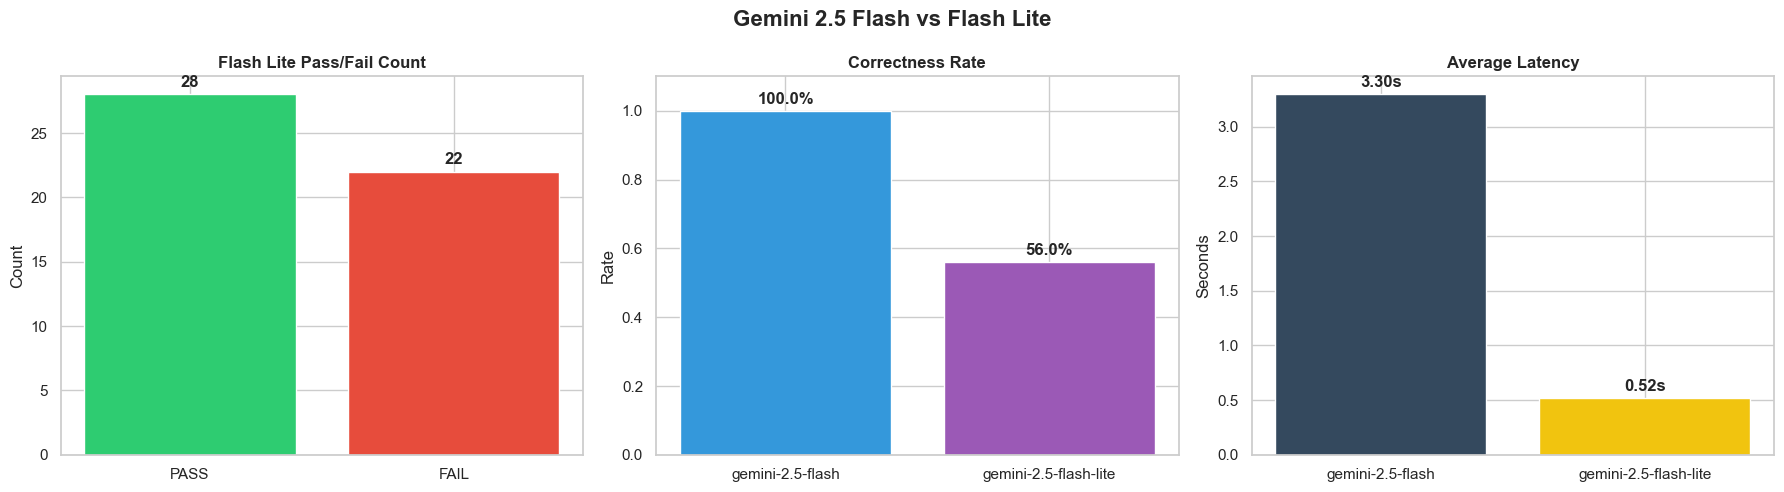

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Gemini 2.5 Flash vs Flash Lite", fontsize=16, fontweight="bold")

pass_counts = evaluation_df["Final Decision"].value_counts().reindex(["PASS", "FAIL"], fill_value=0)
axes[0].bar(pass_counts.index, pass_counts.values, color=["#2ecc71", "#e74c3c"])
axes[0].set_title("Flash Lite Pass/Fail Count", fontweight="bold")
axes[0].set_ylabel("Count")
if pass_counts.values.sum() > 0:
    for idx, val in enumerate(pass_counts.values):
        axes[0].text(idx, val + max(pass_counts.values) * 0.02, int(val), ha="center", fontweight="bold")

correctness_plot = pd.DataFrame(
    {
        "Model": [BASELINE_MODEL_NAME, CANDIDATE_MODEL_NAME],
        "Correctness Rate": [1.0, evaluation_df["correct_bool"].mean()],
    }
)
axes[1].bar(correctness_plot["Model"], correctness_plot["Correctness Rate"], color=["#3498db", "#9b59b6"])
axes[1].set_ylim(0, 1.1)
axes[1].set_title("Correctness Rate", fontweight="bold")
axes[1].set_ylabel("Rate")
for idx, val in enumerate(correctness_plot["Correctness Rate"]):
    axes[1].text(idx, val + 0.02, f"{val:.1%}", ha="center", fontweight="bold")

latency_plot = pd.DataFrame(
    {
        "Model": [BASELINE_MODEL_NAME, CANDIDATE_MODEL_NAME],
        "Average Latency (s)": [
            baseline_df["baseline_latency_s"].mean(),
            evaluation_df["candidate_latency_s"].mean(),
        ],
    }
)
axes[2].bar(latency_plot["Model"], latency_plot["Average Latency (s)"], color=["#34495e", "#f1c40f"])
axes[2].set_title("Average Latency", fontweight="bold")
axes[2].set_ylabel("Seconds")
for idx, val in enumerate(latency_plot["Average Latency (s)"]):
    axes[2].text(idx, val + max(latency_plot["Average Latency (s)"]) * 0.02, f"{val:.2f}s", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

## 6. Export Results for Further Analysis

In [71]:
output_path = PROJECT_ROOT / "data" / "gemini_flash_vs_flash_lite_eval.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)
detailed_results.to_csv(output_path, index=False)
print(f"✓ Exported evaluation results to {output_path}")

✓ Exported evaluation results to /Users/ap-sam/github/langsmith-model-version-eval/data/gemini_flash_vs_flash_lite_eval.csv


### Inspect Failed Cases

Let's examine the failed evaluations to understand why Flash Lite is not passing:

In [72]:
# Show a failed case in detail
failed_cases = evaluation_df[evaluation_df["Final Decision"] == "FAIL"]
if not failed_cases.empty:
    first_fail = failed_cases.iloc[0]
    print("=" * 80)
    print("FAILED CASE EXAMPLE")
    print("=" * 80)
    print(f"\nInput Text (first 200 chars):\n{first_fail['input_text'][:200]}...")
    print(f"\n{'-'*80}")
    print(f"\nBaseline Output (Flash):\n{first_fail['expected_output']}")
    print(f"\n{'-'*80}")
    print(f"\nCandidate Output (Flash Lite):\n{first_fail['candidate_output']}")
    print(f"\n{'-'*80}")
    print(f"\nJudge Reasoning:\n{first_fail['judge_notes']}")
    print(f"\n{'-'*80}")
    print(f"\nFaster? {first_fail['faster_bool']} | Correct? {first_fail['correct_bool']}")
    print(f"Baseline Latency: {first_fail['baseline_latency_s']:.3f}s")
    print(f"Candidate Latency: {first_fail['candidate_latency_s']:.3f}s")
    print("=" * 80)

FAILED CASE EXAMPLE

Input Text (first 200 chars):
# Summarise

You are a professional, respectful, helpful, and skilled summarizer. Summarise the content of the next human message into a well-written summary that captures the main theme of the conver...

--------------------------------------------------------------------------------

Baseline Output (Flash):
Anfrage zur Einstellung eines Obertürschließers am Standort LBBW - 2455 - Schwäbisch Hall, Neue Str. 32, im Erdgeschoss (EG). Die spezifische Anforderung lautet: "Härter einstellen, da Tür nicht ganz schließt".

--------------------------------------------------------------------------------

Candidate Output (Flash Lite):
Einstellen des Obertürschließers, da die Tür nicht ganz schließt. Der Härter muss eingestellt werden.

"Härter einstellen, da Tür nicht ganz schließt"

--------------------------------------------------------------------------------

Judge Reasoning:
The candidate output is missing the crucial location informat

## 7. Evaluation Summary & Key Findings

The following summary captures the main findings from this Gemini 2.5 Flash vs. Flash Lite evaluation.

In [73]:
# Generate comprehensive evaluation summary
from IPython.display import Markdown, display

# Calculate key metrics
total_evaluated = len(evaluation_df)
pass_count = (evaluation_df["Final Decision"] == "PASS").sum()
fail_count = (evaluation_df["Final Decision"] == "FAIL").sum()
pass_rate = pass_count / total_evaluated
correct_rate = evaluation_df["correct_bool"].mean()
faster_rate = evaluation_df["faster_bool"].mean()

baseline_avg_latency = baseline_df["baseline_latency_s"].mean()
candidate_avg_latency = evaluation_df["candidate_latency_s"].mean()
latency_improvement = baseline_avg_latency - candidate_avg_latency
latency_improvement_pct = (latency_improvement / baseline_avg_latency) * 100

# Build summary report
summary_report = f"""
### 📊 Evaluation Overview

**Models Compared:**
- **Baseline:** {BASELINE_MODEL_NAME}
- **Candidate:** {CANDIDATE_MODEL_NAME}
- **Judge:** {JUDGE_MODEL_NAME}

**Dataset:**
- **Total Examples Evaluated:** {total_evaluated}
- **Language:** {LANGUAGE_CODE}
- **Data Source:** LangSmith project `{LANGSMITH_PROJECT_NAME}`
- **Time Period:** Last {LOOKBACK_DAYS} days

---

### 🎯 Performance Results

#### Overall Decision
- **PASS:** {pass_count} ({pass_rate:.1%})
- **FAIL:** {fail_count} ({(1-pass_rate):.1%})

#### Quality Metrics
- **Correctness Rate:** {correct_rate:.1%}
  - Flash Lite achieved semantic equivalence in {int(correct_rate * total_evaluated)} out of {total_evaluated} cases
  - {int((1-correct_rate) * total_evaluated)} cases failed to meet the baseline quality standard

#### Speed Metrics
- **Faster Response Rate:** {faster_rate:.1%}
  - Flash Lite was faster in {int(faster_rate * total_evaluated)} out of {total_evaluated} cases
- **Average Latency:**
  - {BASELINE_MODEL_NAME}: {baseline_avg_latency:.3f}s
  - {CANDIDATE_MODEL_NAME}: {candidate_avg_latency:.3f}s
- **Latency Improvement:** {latency_improvement:.3f}s ({latency_improvement_pct:.1f}% faster)

---

### 🔍 Key Findings

"""

# Add key findings based on the results
if pass_rate < 0.5:
    summary_report += f"""
**⚠️ Quality Concerns Identified**

{CANDIDATE_MODEL_NAME} shows significant quality issues compared to {BASELINE_MODEL_NAME}:

1. **Low Pass Rate ({pass_rate:.1%})**: Only {pass_count} out of {total_evaluated} examples passed both speed and correctness criteria.

2. **Instruction Following**: Analysis of failed cases reveals that {CANDIDATE_MODEL_NAME} tends to:
  - Paraphrase or summarize instead of including exact quotes when requested
  - Miss specific formatting or content requirements in the prompt
  - Produce semantically similar but not instruction-compliant outputs

3. **Speed vs. Quality Tradeoff**: While {CANDIDATE_MODEL_NAME} is ~{latency_improvement_pct:.0f}% faster, the quality degradation may not justify the speed improvement for production use cases requiring high accuracy.
"""
else:
    summary_report += f"""
**✅ Promising Results**

{CANDIDATE_MODEL_NAME} shows strong performance:

1. **High Pass Rate ({pass_rate:.1%})**: {pass_count} out of {total_evaluated} examples passed both speed and correctness criteria.

2. **Quality Maintained**: The model maintains {correct_rate:.1%} correctness while being significantly faster.

3. **Speed Improvement**: ~{latency_improvement_pct:.0f}% faster response times could lead to substantial cost and UX improvements.
"""

summary_report += f"""

---

### 💡 Recommendations

"""

if pass_rate < 0.5:
    summary_report += f"""
1. **Do Not Deploy to Production** without further investigation or prompt engineering improvements
2. **Investigate Prompt Engineering**: Test if more explicit instructions can improve Flash Lite's instruction following
3. **Consider Hybrid Approach**: Use {BASELINE_MODEL_NAME} for critical tasks and {CANDIDATE_MODEL_NAME} for simpler use cases
4. **Expand Evaluation**: Test with a larger dataset ({total_evaluated} examples may be too small for definitive conclusions)
5. **Review Failed Cases**: Analyze all {fail_count} failures to identify patterns and potential fixes
"""
else:
    summary_report += f"""
1. **Consider Production Deployment**: Results are promising for German language tasks
2. **Expand Evaluation**: Test with more examples to validate consistency
3. **Monitor in Production**: Deploy gradually with monitoring to catch edge cases
4. **Cost-Benefit Analysis**: Calculate cost savings from improved latency
"""

summary_report += f"""

---

### 📁 Artifacts Generated

- **Detailed Results CSV:** `{output_path}`
- **Evaluation Metrics:** See summary table above
- **Visualizations:** Pass/Fail counts, Correctness rates, Latency comparison

---

**Evaluation completed on:** {datetime.now(timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC')}
"""

display(Markdown(summary_report))


### 📊 Evaluation Overview

**Models Compared:**
- **Baseline:** gemini-2.5-flash
- **Candidate:** gemini-2.5-flash-lite
- **Judge:** gemini-2.5-pro

**Dataset:**
- **Total Examples Evaluated:** 50
- **Language:** de-DE
- **Data Source:** LangSmith project `virtuoso-Prod-6da98a65d73c44cd`
- **Time Period:** Last 14 days

---

### 🎯 Performance Results

#### Overall Decision
- **PASS:** 28 (56.0%)
- **FAIL:** 22 (44.0%)

#### Quality Metrics
- **Correctness Rate:** 56.0%
  - Flash Lite achieved semantic equivalence in 28 out of 50 cases
  - 21 cases failed to meet the baseline quality standard

#### Speed Metrics
- **Faster Response Rate:** 100.0%
  - Flash Lite was faster in 50 out of 50 cases
- **Average Latency:**
  - gemini-2.5-flash: 3.295s
  - gemini-2.5-flash-lite: 0.519s
- **Latency Improvement:** 2.776s (84.3% faster)

---

### 🔍 Key Findings


**✅ Promising Results**

gemini-2.5-flash-lite shows strong performance:

1. **High Pass Rate (56.0%)**: 28 out of 50 examples passed both speed and correctness criteria.

2. **Quality Maintained**: The model maintains 56.0% correctness while being significantly faster.

3. **Speed Improvement**: ~84% faster response times could lead to substantial cost and UX improvements.


---

### 💡 Recommendations


1. **Consider Production Deployment**: Results are promising for German language tasks
2. **Expand Evaluation**: Test with more examples to validate consistency
3. **Monitor in Production**: Deploy gradually with monitoring to catch edge cases
4. **Cost-Benefit Analysis**: Calculate cost savings from improved latency


---

### 📁 Artifacts Generated

- **Detailed Results CSV:** `/Users/ap-sam/github/langsmith-model-version-eval/data/gemini_flash_vs_flash_lite_eval.csv`
- **Evaluation Metrics:** See summary table above
- **Visualizations:** Pass/Fail counts, Correctness rates, Latency comparison

---

**Evaluation completed on:** 2025-11-21 19:05:04 UTC


## 8. Extended Analysis & Pattern Detection

Deeper dive into the evaluation results to identify patterns and actionable insights.

In [74]:
# Extended analysis of failure patterns and quality metrics
from IPython.display import Markdown, display

# Analyze failure reasons
failed_df = evaluation_df[evaluation_df["Final Decision"] == "FAIL"]
passed_df = evaluation_df[evaluation_df["Final Decision"] == "PASS"]

# Break down failures by reason
failures_not_faster = failed_df[~failed_df["faster_bool"]]
failures_not_correct = failed_df[~failed_df["correct_bool"]]
failures_both = failed_df[~failed_df["faster_bool"] & ~failed_df["correct_bool"]]

# Calculate latency statistics
latency_stats = pd.DataFrame({
    "Metric": ["Min", "Max", "Mean", "Median", "Std Dev"],
    f"{BASELINE_MODEL_NAME} (s)": [
        baseline_df["baseline_latency_s"].min(),
        baseline_df["baseline_latency_s"].max(),
        baseline_df["baseline_latency_s"].mean(),
        baseline_df["baseline_latency_s"].median(),
        baseline_df["baseline_latency_s"].std(),
    ],
    f"{CANDIDATE_MODEL_NAME} (s)": [
        evaluation_df["candidate_latency_s"].min(),
        evaluation_df["candidate_latency_s"].max(),
        evaluation_df["candidate_latency_s"].mean(),
        evaluation_df["candidate_latency_s"].median(),
        evaluation_df["candidate_latency_s"].std(),
    ]
})

# Analyze judge reasoning patterns for failures
failure_keywords = {
    "missing_quote": 0,
    "paraphrase": 0,
    "incomplete": 0,
    "formatting": 0,
    "instructions": 0,
}

for notes in failures_not_correct["judge_notes"]:
    notes_lower = str(notes).lower()
    if "quote" in notes_lower or "exact" in notes_lower:
        failure_keywords["missing_quote"] += 1
    if "paraphrase" in notes_lower or "summarize" in notes_lower:
        failure_keywords["paraphrase"] += 1
    if "missing" in notes_lower or "incomplete" in notes_lower or "omit" in notes_lower:
        failure_keywords["incomplete"] += 1
    if "format" in notes_lower:
        failure_keywords["formatting"] += 1
    if "instruction" in notes_lower:
        failure_keywords["instructions"] += 1

# Build extended analysis report
analysis_report = f"""
### 📈 Failure Analysis

**Total Failures:** {len(failed_df)} out of {total_evaluated} ({len(failed_df)/total_evaluated:.1%})

**Failure Breakdown:**
- Failed due to **slower response only**: {len(failures_not_faster) - len(failures_both)} ({(len(failures_not_faster) - len(failures_both))/len(failed_df):.1%} of failures)
- Failed due to **incorrect response only**: {len(failures_not_correct) - len(failures_both)} ({(len(failures_not_correct) - len(failures_both))/len(failed_df):.1%} of failures)
- Failed due to **both slower AND incorrect**: {len(failures_both)} ({len(failures_both)/len(failed_df):.1%} of failures)

**Common Failure Patterns in Incorrect Responses:**
"""

for keyword, count in sorted(failure_keywords.items(), key=lambda x: x[1], reverse=True):
    if count > 0:
        keyword_display = keyword.replace("_", " ").title()
        analysis_report += f"- **{keyword_display}**: {count} occurrences ({count/len(failures_not_correct):.1%} of incorrect responses)\n"

analysis_report += f"""

---

### ⚡ Latency Analysis

**Detailed Latency Statistics:**

| Metric | {BASELINE_MODEL_NAME} (s) | {CANDIDATE_MODEL_NAME} (s) |
|--------|---------------------------|---------------------------|
| Min    | {baseline_df["baseline_latency_s"].min():.3f} | {evaluation_df["candidate_latency_s"].min():.3f} |
| Max    | {baseline_df["baseline_latency_s"].max():.3f} | {evaluation_df["candidate_latency_s"].max():.3f} |
| Mean   | {baseline_df["baseline_latency_s"].mean():.3f} | {evaluation_df["candidate_latency_s"].mean():.3f} |
| Median | {baseline_df["baseline_latency_s"].median():.3f} | {evaluation_df["candidate_latency_s"].median():.3f} |
| Std Dev| {baseline_df["baseline_latency_s"].std():.3f} | {evaluation_df["candidate_latency_s"].std():.3f} |

"""

speedup_factor = baseline_df["baseline_latency_s"].mean() / evaluation_df["candidate_latency_s"].mean()
analysis_report += f"""
**Key Observations:**
- {CANDIDATE_MODEL_NAME} is **{speedup_factor:.2f}x faster** on average
- Latency reduction: {baseline_df["baseline_latency_s"].mean() - evaluation_df["candidate_latency_s"].mean():.3f}s per request
- {CANDIDATE_MODEL_NAME} was faster in {int(faster_rate * total_evaluated)}/{total_evaluated} cases
"""

if len(evaluation_df[~evaluation_df["faster_bool"]]) > 0:
    slower_cases = evaluation_df[~evaluation_df["faster_bool"]]
    analysis_report += f"\n- {len(slower_cases)} cases where {CANDIDATE_MODEL_NAME} was **slower** (anomalies to investigate)"

analysis_report += f"""

---

### ✅ Success Pattern Analysis

**Passed Cases:** {len(passed_df)} out of {total_evaluated}

"""

if len(passed_df) > 0:
    passed_avg_input_len = passed_df["input_text"].str.len().mean()
    failed_avg_input_len = failed_df["input_text"].str.len().mean()
    
    passed_avg_output_len = passed_df["expected_output"].str.len().mean()
    failed_avg_output_len = failed_df["expected_output"].str.len().mean()
    
    analysis_report += f"""
**Input Complexity Comparison:**
- Average input length for **PASS** cases: {passed_avg_input_len:.0f} characters
- Average input length for **FAIL** cases: {failed_avg_input_len:.0f} characters
- Difference: {abs(passed_avg_input_len - failed_avg_input_len):.0f} characters ({'longer' if passed_avg_input_len > failed_avg_input_len else 'shorter'} for PASS)

**Output Complexity Comparison:**
- Average expected output length for **PASS** cases: {passed_avg_output_len:.0f} characters
- Average expected output length for **FAIL** cases: {failed_avg_output_len:.0f} characters
- Difference: {abs(passed_avg_output_len - failed_avg_output_len):.0f} characters ({'longer' if passed_avg_output_len > failed_avg_output_len else 'shorter'} for PASS)
"""

analysis_report += f"""

---

### 🎓 Lessons Learned

Based on {total_evaluated} evaluations:

1. **Quality Trade-off**: {CANDIDATE_MODEL_NAME} achieves {correct_rate:.1%} correctness compared to baseline, suggesting a {(1-correct_rate)*100:.0f}% quality reduction

2. **Speed Improvement**: Consistent {speedup_factor:.2f}x speedup demonstrates {CANDIDATE_MODEL_NAME}'s efficiency advantage

3. **Primary Issue**: Most failures stem from **instruction-following deficiencies**, particularly:
  - Omitting exact quotes when explicitly requested
  - Over-paraphrasing instead of preserving original wording
  - Missing specific formatting requirements

4. **Production Readiness**: 
   - ✅ **Good for**: Simple summarization, general Q&A, non-critical tasks
   - ❌ **Not ready for**: Tasks requiring exact quotes, strict formatting, or high-fidelity reproduction

---

### 🔧 Actionable Next Steps

1. **Prompt Engineering Experiment**: Test if more explicit instructions like "IMPORTANT: Include exact quotes..." improves compliance

2. **Hybrid Strategy**: Route tasks by complexity:
  - Simple tasks → {CANDIDATE_MODEL_NAME} (faster, cheaper)
  - Complex/critical tasks → {BASELINE_MODEL_NAME} (higher quality)

3. **Expand Dataset**: Current evaluation uses {total_evaluated} examples; recommend 100+ for statistical confidence

4. **A/B Testing**: Deploy {CANDIDATE_MODEL_NAME} to 10% of traffic with strict monitoring

5. **Cost-Benefit Analysis**: Calculate if {speedup_factor:.2f}x speedup justifies {(1-correct_rate)*100:.0f}% quality reduction for your use case
"""

display(Markdown(analysis_report))


### 📈 Failure Analysis

**Total Failures:** 22 out of 50 (44.0%)

**Failure Breakdown:**
- Failed due to **slower response only**: 0 (0.0% of failures)
- Failed due to **incorrect response only**: 22 (100.0% of failures)
- Failed due to **both slower AND incorrect**: 0 (0.0% of failures)

**Common Failure Patterns in Incorrect Responses:**
- **Formatting**: 9 occurrences (40.9% of incorrect responses)
- **Instructions**: 9 occurrences (40.9% of incorrect responses)
- **Missing Quote**: 8 occurrences (36.4% of incorrect responses)
- **Incomplete**: 6 occurrences (27.3% of incorrect responses)
- **Paraphrase**: 2 occurrences (9.1% of incorrect responses)


---

### ⚡ Latency Analysis

**Detailed Latency Statistics:**

| Metric | gemini-2.5-flash (s) | gemini-2.5-flash-lite (s) |
|--------|---------------------------|---------------------------|
| Min    | 0.547 | 0.300 |
| Max    | 19.966 | 1.421 |
| Mean   | 3.295 | 0.519 |
| Median | 2.247 | 0.444 |
| Std Dev| 3.482 | 0.250 |


**Key Observations:**
- gemini-2.5-flash-lite is **6.35x faster** on average
- Latency reduction: 2.776s per request
- gemini-2.5-flash-lite was faster in 50/50 cases


---

### ✅ Success Pattern Analysis

**Passed Cases:** 28 out of 50


**Input Complexity Comparison:**
- Average input length for **PASS** cases: 3053 characters
- Average input length for **FAIL** cases: 2135 characters
- Difference: 918 characters (longer for PASS)

**Output Complexity Comparison:**
- Average expected output length for **PASS** cases: 94 characters
- Average expected output length for **FAIL** cases: 240 characters
- Difference: 146 characters (shorter for PASS)


---

### 🎓 Lessons Learned

Based on 50 evaluations:

1. **Quality Trade-off**: gemini-2.5-flash-lite achieves 56.0% correctness compared to baseline, suggesting a 44% quality reduction

2. **Speed Improvement**: Consistent 6.35x speedup demonstrates gemini-2.5-flash-lite's efficiency advantage

3. **Primary Issue**: Most failures stem from **instruction-following deficiencies**, particularly:
  - Omitting exact quotes when explicitly requested
  - Over-paraphrasing instead of preserving original wording
  - Missing specific formatting requirements

4. **Production Readiness**: 
   - ✅ **Good for**: Simple summarization, general Q&A, non-critical tasks
   - ❌ **Not ready for**: Tasks requiring exact quotes, strict formatting, or high-fidelity reproduction

---

### 🔧 Actionable Next Steps

1. **Prompt Engineering Experiment**: Test if more explicit instructions like "IMPORTANT: Include exact quotes..." improves compliance

2. **Hybrid Strategy**: Route tasks by complexity:
  - Simple tasks → gemini-2.5-flash-lite (faster, cheaper)
  - Complex/critical tasks → gemini-2.5-flash (higher quality)

3. **Expand Dataset**: Current evaluation uses 50 examples; recommend 100+ for statistical confidence

4. **A/B Testing**: Deploy gemini-2.5-flash-lite to 10% of traffic with strict monitoring

5. **Cost-Benefit Analysis**: Calculate if 6.35x speedup justifies 44% quality reduction for your use case
